In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import matplotlib as mpl 
import os
from seaborn import color_palette
mpl.rc('text', usetex = False)
import seaborn as sns
from scipy.fft import rfftn, irfftn,fftfreq

## Simulation details

In [2]:
N = 1024
num_slabs = 512
nu = 2e-3
isforcing = True

In [3]:
PI = np.pi
TWO_PI = 2*PI
Nf = N//2 + 1
Nd = np.round(2/3**0.5*Nf,0).astype(int)
Np = N
L = TWO_PI
X = Y = Z = np.linspace(0, L, N, endpoint= False)
dx,dy,dz = X[1]-X[0], Y[1]-Y[0], Z[1]-Z[0]


Kx = Ky = Kz = fftfreq(N,  1./N)*TWO_PI/L
Kz = Kz[:Nf]

In [4]:
loadPath = lambda t : pathlib.Path(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_{isforcing}/N_{N}_Re_{1/nu:.1f}/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"/home/rajarshi.chattopadhyay/python/3D-DNS/data/forced/N_128_Re_600.0/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"./data/forced_{isforcing}/N_{N}_Re_{1/nu:.1f}/time_{t:.1f}")
print(loadPath(0).exists())
print(loadPath(0))
# "/mnt/pfs/rajarshi.chattopadhyay/3D-DNS/data/forced_True/N_128_Re_200.0/time_0.0"

True
/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/data/forced_True/N_1024_Re_500.0/time_0.0


In [5]:
times = [float(i.split("_")[-1]) for i in os.listdir(loadPath(0).parent) if "time" in i]
times.sort()
times[-1]

25.0

# <center> Loading the velocity field 

In [ ]:
x, y, z = np.meshgrid(X, Y, Z, indexing='ij')

kx,  ky,  kz = np.meshgrid(Kx,  Ky,  Kz,  indexing = 'ij')
k = (kx**2 + ky**2 + kz**2)**0.5


In [23]:

# np.load(f"/mnt/pfs/rajarshi.chattopadhyay/3D-DNS/data/zero-start/time_10.0/Fields_56.npz")["u"].shape
u = np.zeros((N,N,N))
v = np.zeros((N,N,N))
w = np.zeros((N,N,N))
# times = np.array(list(np.arange(0,200.5,10)) )#+  list(np.arange(50.9,100.5,1.0)))


In [30]:
t = 2.0
Ns= N//num_slabs
for i in range(num_slabs):
    data = np.load(loadPath(t)/f"Fields_{i}.npz")
    u[i*Ns:(i+1)*Ns] = data["u"]
    print(f"done for slab {i}",end = "\r")

In [46]:
import subprocess

cmap= color_palette("icefire",as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter = 0)
# p1 = plt.imshow(u[...,0],cmap = cmap,alpha = 0.9)
# plt.colorbar(p1)
output_dir = pathlib.Path("/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images")
output_dir.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(10, 10), dpi=300)
plt.axis('off')
plt.gca().set_facecolor('none')
plt.gca().set_alpha(0)
for zslab in range(N):
    p1 = plt.imshow(u[..., zslab], cmap=cmap, norm=norm, alpha=1.0)
    cbar = plt.colorbar(p1, shrink=0.5)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    plt.title(f"Z-slab {zslab}")
    plt.tight_layout()
    plt.savefig(output_dir / f"zslab_{zslab}.png",transparent = True)
    plt.clf()
    print(f"Done for slab {zslab}", end="\r")
# Run the ffmpeg command


<Figure size 3000x3000 with 0 Axes>

In [48]:
subprocess.run([
    'ffmpeg', '-framerate', '60', '-i', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/zslab_%d.png',
    '-vcodec', 'libx265', '-pix_fmt', 'yuv420p', '-crf', '1', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/z_span.mp4'
])

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-1)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1732155191655/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopen

CompletedProcess(args=['ffmpeg', '-framerate', '60', '-i', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/zslab_%d.png', '-vcodec', 'libx265', '-pix_fmt', 'yuv420p', '-crf', '1', '/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/output_images/z_span.mp4'], returncode=0)

# <center> Time series + Kolmogorov Length scale

In [7]:
tload = times
ke = np.zeros(len(tload))
ens = np.zeros(len(tload))
pe = np.zeros(len(tload))
eta = np.zeros(len(tload))
for ii,t in enumerate(tload):
    print('Loading Done for time:',t,end = '\r')

    # ke[ii] = np.sum(np.load(loadPath(t)/f"KE_spectrum.npz")["ek"])
    ek = np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]
    ke[ii] = np.sum(ek)
    ens[ii] = np.sum(np.arange(N//2 +1 )**2*ek)
    eta[ii] = (nu**3/ (nu *np.sum(np.arange(Nf)**2 * 2 * (ek)/(TWO_PI**3))))**0.25
    # pe[ii] = np.sum(np.load(loadPath(t)/f"PE_spectrum.npz")["ek"])

Text(0, 0.5, '$E$')

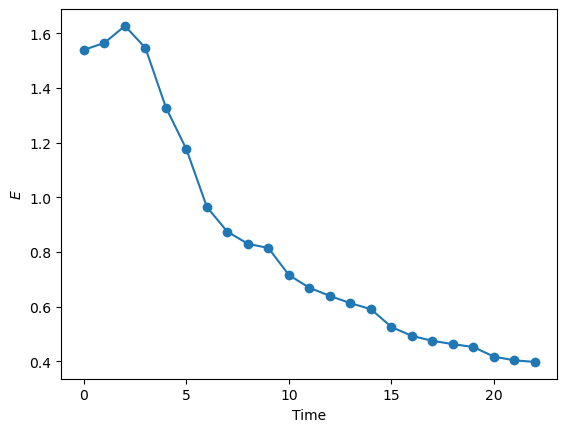

In [9]:
# plt.plot(tload,eta,'x-')
plt.plot(tload,ke/(TWO_PI**3),'o-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,10)   
# plt.xlim(0,150) 
#plt.yscale('log',base = 2)
plt.xlabel('Time')

plt.ylabel('$E$')

Text(0, 0.5, '$E$')

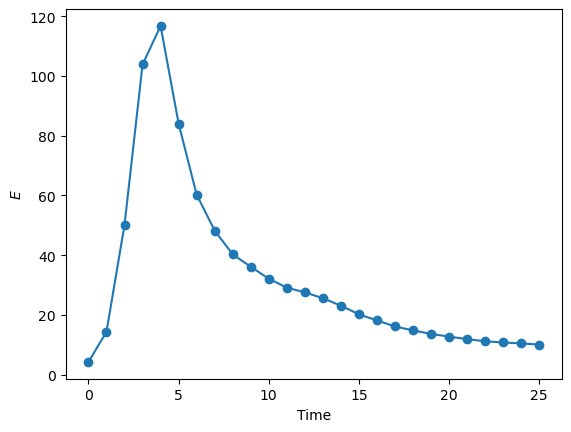

In [8]:
# plt.plot(tload,eta,'x-')
plt.plot(tload,ens/(TWO_PI**3),'o-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,10)   
# plt.xlim(0,150) 
#plt.yscale('log',base = 2)
plt.xlabel('Time')

plt.ylabel('$E$')

Text(0, 0.5, '$k_{max}\\eta$')

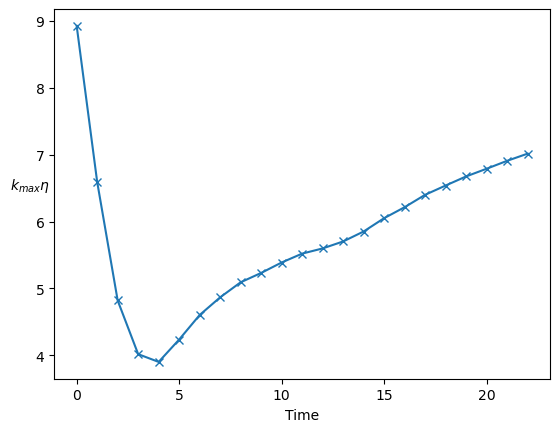

In [10]:
plt.plot(tload,eta*(N//3),'x-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,2)   
# plt.xlim(0,150) 
# plt.yscale('log',base = 2)
plt.xlabel('Time')
plt.ylabel('$k_{max}\eta$',rotation = 0)

# <center> Energy Spectrum

In [10]:
cls = sns.color_palette("Set1", len(times))
cls

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

0.02111524986841342 87.27659531296854 3.441250704566772 7.200300205128976 0.04024436570619199


(1, 351)

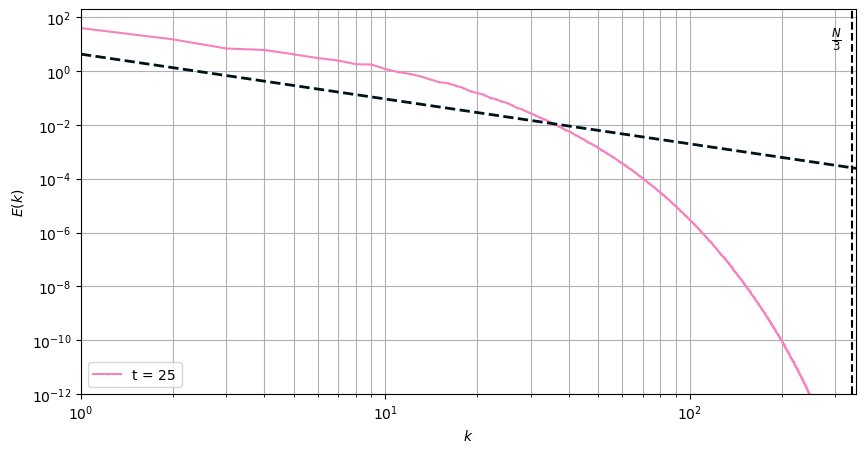

In [14]:
plt.figure(figsize = (10,5))
k1d = np.arange(Nf)
for t in times[-1:]:
    print('Loding Done for time:',t,end = '\r')
    ek =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]
    dissip = 2*nu*np.sum(ek*k1d**2)/TWO_PI**3
    eta = (nu**3/ dissip)**0.25
    print(eta,ek.sum(),eta/(TWO_PI/N),N//3*eta,dissip)
    xdat = k1d[1:]
    ydat = ek[1:]#*(xdat)**(5/3.)/(TWO_PI**3)
    plt.plot(xdat,ydat,".-",label = f"t = {t:.0f}", color = cls[times.index(t)],markersize = 1)
    
ydat =0.5*dissip**(-2/3)*xdat**(-5/3)
plt.plot(xdat,ydat,'--',lw = 2,color = "#001219")
line = np.array([1.2,100])
# plt.plot(line,1e3*line**(-3.),"--",color = "black")
# plt.text(5,80,r"$k^{-3}$",fontsize = 12)
# plt.plot(line,1e2*line**(-5/3.),"--",color = "black")
# plt.text(20,80,r"$k^{-\frac53}$",fontsize = 12)

plt.axvline(1/3*N, linestyle='--', color='black')
plt.text(int(1/3*N*0.85), 10, r'$\frac{N}{3}$', fontsize=12)  # Add text label
# plt.axvline(Nd, linestyle='--', color='black')
# plt.text(Nd*0.8, 10, r'$\frac{N}{\sqrt{3}}$', fontsize=12)  # Add text label
# plt.axhline(5e-5, linestyle='--', color='black')
# plt.text(1, 1.5*5e-5, r'$k^2$', fontsize=12)  # Add text label

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)$")
plt.legend(loc ='lower left')
plt.grid(which = "both")

plt.ylim(1e-12,200)
plt.xlim(1, N//3+10)


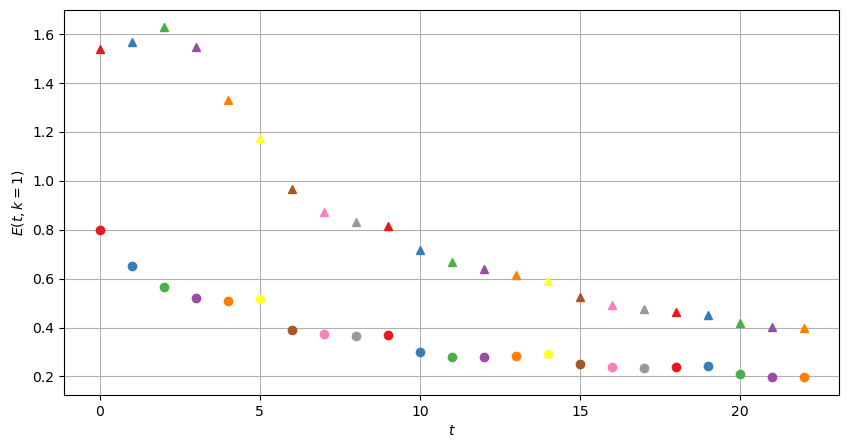

In [13]:
plt.figure(figsize = (10,5))
k1d = np.arange(Nf)
for t in times:
    print('Loding Done for time:',t,end = '\r')
    e1 =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"][1]/(TWO_PI**3)
    et = np.sum(np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]/(TWO_PI**3))
    xdat = t
    ydat = e1
    plt.plot(xdat,ydat,"o", color = cls[times.index(t)])
    ydat = et
    plt.plot(xdat,ydat,"^", color = cls[times.index(t)])
    
plt.xlabel(r"$t$")
plt.ylabel(r"$E(t,k =1)$")
# plt.legend(loc ='best')
plt.grid(which = "both")



# <center> Structure Function

In [7]:
p = 1
r = dx*np.arange(Nf)

In [8]:
color = ["264653","2a9d8f","e9c46a","f4a261","e76f51"]

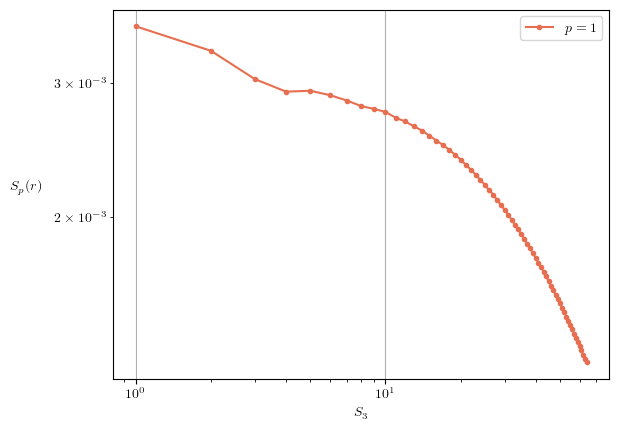

In [15]:
for p in range(1,2):
    sfunc = np.load(f"/mnt/pfs/rajarshi.chattopadhyay/codes/HIT_3D/struct-func-{p:.1f}-N-{N}.npy")
    # s3 = np.load(f"/mnt/pfs/rajarshi.chattopadhyay/codes/3D-DNS/pstprc_data/struct-func-{3:.1f}-N-512.npy")
    # poly = np.polyfit(np.log(s3[1:]),np.log(sfunc[1:]),1)
    # print(poly[0],p/3)
    line1 = np.array([1,20])
    line2 = np.array([30,256])
    cls = "#" + color[-p]
    plt.plot(r[1:]/dx,sfunc[1:]*(r[1:]**(-p)),'.-',label = f"$p = {p}$",color =cls)
    # plt.plot(s3[1:],(sfunc[1:] - sfunc[:-1])/(s3[1:]-s3[:-1]),'.-',label = f"Slope $ p = {p}$",color =cls )
    # plt.plot(line1,5e-2*line1**(p),"--",color =cls)
    # plt.plot(line2,5e-2*line2**(p/3),"--",color =cls)
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.xlim(1e-7,1e-3)
# plt.ylim(1e-9,1e-1)
plt.xlabel(r"$S_3$")
plt.ylabel(r"$S_p(r)$",rotation = 0,labelpad = 20)
# plt.ylabel(r"Slope",rotation = 0,labelpad = 20)
plt.grid()